## Softmax Regression

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pca import PCA
import argparse
import network
import os, random, sys
from data import traffic_sign, generate_k_fold_set, onehot_encode, onehot_decode, z_score_normalize
from model.softmax import SoftmaxRegression

In [5]:
### Q6(a) - Evaluate Network on all 43 traffic signs (aligned dataset)

# Load aligned data
X, y = traffic_sign(True)
X = X.astype(np.float32) # cast to float32 as float64 running out of memory
X = z_score_normalize(X) 

print(X.shape)
print(y.shape)
print(X.dtype)
print(y.dtype)

(34799, 1024)
(34799,)
float32
uint8


**********
(27841, 1024)
(27841, 300)


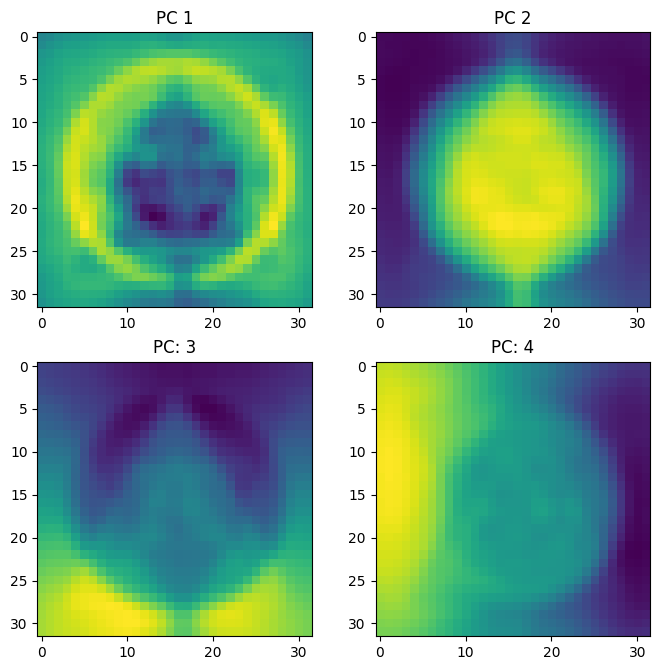

 epoch: 50, train accuracy: 0.8393376674688409, train_loss_ex:1.2772981071785343, train_loss_class: 827.0059674873854, valid_loss_ex: 2.018642093640497, valid_loss_class: 163.32222892500673, valid_acc: 0.8246622592699051
 epoch: 100, train accuracy: 0.8597033152544808, train_loss_ex:0.9379577789742497, train_loss_class: 607.2949424284205, valid_loss_ex: 1.8134676185542498, valid_loss_class: 146.72218244070314, valid_acc: 0.8424834722621443
 epoch: 150, train accuracy: 0.8737832692791208, train_loss_ex:0.7887429179292778, train_loss_class: 510.6835250713726, valid_loss_ex: 1.687715520920743, valid_loss_class: 136.5479604019364, valid_acc: 0.8534061511928716
 epoch: 200, train accuracy: 0.8843073165475378, train_loss_ex:0.7001447733673544, train_loss_class: 453.31931710047706, valid_loss_ex: 1.5752004861960267, valid_loss_class: 127.44470910409248, valid_acc: 0.8631790744466801
 epoch: 250, train accuracy: 0.8918501490607378, train_loss_ex:0.6394850734741552, train_loss_class: 414.044277

KeyboardInterrupt: 

In [6]:
# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record_ex = []
train_loss_record_class = []
train_accuracy_record = []
holdout_loss_record_ex = []
holdout_loss_record_class = []
holdout_accuracy_record = []
test_accuracy_record = []


# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 300
epochs_print = [50, 100, 150, 200, 250, 300]

for train, valid, test in generate_k_fold_set((X, y), 10):
    print("**********")
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    print(train_data.shape)
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data)
    print(projected.shape)
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = projected     
    valid_d = pca.PCA_generate(valid_data)
    test_d = pca.PCA_generate(test_data)

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    
    # Onehot encode labels
    y_true = onehot_encode(train_label)
    
    for epoch in range(num_epochs):
        y_hat = softmax_model.model(train_d)
        
        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_ex = raw_train_loss / len(train_d) # train loss per example
        train_loss_class = raw_train_loss / num_classes # train loss per class
        
        # Update Weights
        softmax_model.update_weights(train_d, y_true, y_hat)
        
        train_loss_record_ex.append(train_loss_ex)
        train_loss_record_class.append(train_loss_class)
        
        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        # TODO: early stopping, plotting std.dev., etc.
        holdout_y = softmax_model.model(valid_d)

        valid_label_onehot = onehot_encode(valid_label)

        holdout_loss = softmax_model.cross_entropy(holdout_y, valid_label_onehot)
        holdout_loss_ex = holdout_loss / len(valid_d) # holdout loss per example
        holdout_loss_class = holdout_loss / num_classes # holdout loss per class

        holdout_accuracy = softmax_model.accuracy(holdout_y, valid_label_onehot)
        holdout_loss_record_ex.append(holdout_loss_ex)
        holdout_loss_record_class.append(holdout_loss_class)
        holdout_accuracy_record.append(holdout_accuracy)

        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy}, train_loss_ex:{train_loss_ex}, train_loss_class: {train_loss_class}, '\
                f'valid_loss_ex: {holdout_loss_ex}, valid_loss_class: {holdout_loss_class}, valid_acc: {holdout_accuracy}')
plt.figure(1)
plt.plot('loss per ex', train_loss_record_ex[0], holdout_loss_record_ex[0])
plt.figure(2)
plt.plot('loss per class', train_loss_record_class[0], holdout_loss_record_class[0])
plt.figure(3)
plt.plot('accuracy', train_accuracy_record[0], holdout_accuracy_record[0])


In [9]:
### Q6(b) - Stochastic Gradient Descent

# Softmax Regression Parameters
lr = 0.5
num_features = X.shape[1]
num_classes = y.max() + 1

train_loss_record = []
train_accuracy_record = []
holdout_loss_record = []
holdout_accuracy_record = []
test_accuracy_record = []


# PCA number of principal components
n_components = 300

first_plot = True

num_epochs = 1000
epochs_print = [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]

for train, valid, test in generate_k_fold_set((X, y), k = 10):
    train_data, train_label = train
    valid_data, valid_label = valid
    test_data, test_label = test
    
    # Project data onto principal components
    pca = PCA(n_components)
    projected = pca.fit_transform(train_data)
    print(projected.shape)
    
    # Plot principal components
    if first_plot == True : 
        pca.plot_PC()
        first_plot = False
    train_d = projected     
    valid_d = pca.PCA_generate(valid_data)
    test_d = pca.PCA_generate(test_data)

    softmax_model = SoftmaxRegression(lr, n_components, num_classes)
    
    # SGD
    for epoch in range(num_epochs):
        # Shuffle indices
        indices = np.arange(len(train_d))
        indices = np.random.shuffle(indices)

        train_d = train_d[indices].squeeze(0)
        train_label = train_label[indices].squeeze(0)
        
        # Onehot encode labels
        y_true = onehot_encode(train_label)
            
        # Iterate over each example
        for i in range(len(train_d)):
            cur_ex = train_d[i][np.newaxis, ...]
            cur_label = y_true[i][np.newaxis, ...]
            y_hat = softmax_model.model(cur_ex)

            # Update Weights
            softmax_model.update_weights(cur_ex, cur_label, y_hat)

        y_hat = softmax_model.model(train_d)

        raw_train_loss = softmax_model.cross_entropy(y_true, y_hat)
        train_loss_ex = raw_train_loss / len(train_d) # train loss per example
        train_loss_class = raw_train_loss / num_classes # train loss per class

        train_loss_record.append(raw_train_loss)

        train_accuracy = softmax_model.accuracy(y_true, y_hat)
        train_accuracy_record.append(train_accuracy)
        
        if (epoch + 1) in epochs_print:
            print(f' epoch: {epoch + 1}, train accuracy: {train_accuracy}, '\
                f'train_loss_ex:{train_loss_ex}, train_loss_class: {train_loss_class}')
